<a href="https://colab.research.google.com/github/smartgrids-aau/GreenCodesPython/blob/main/Exemple_4_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

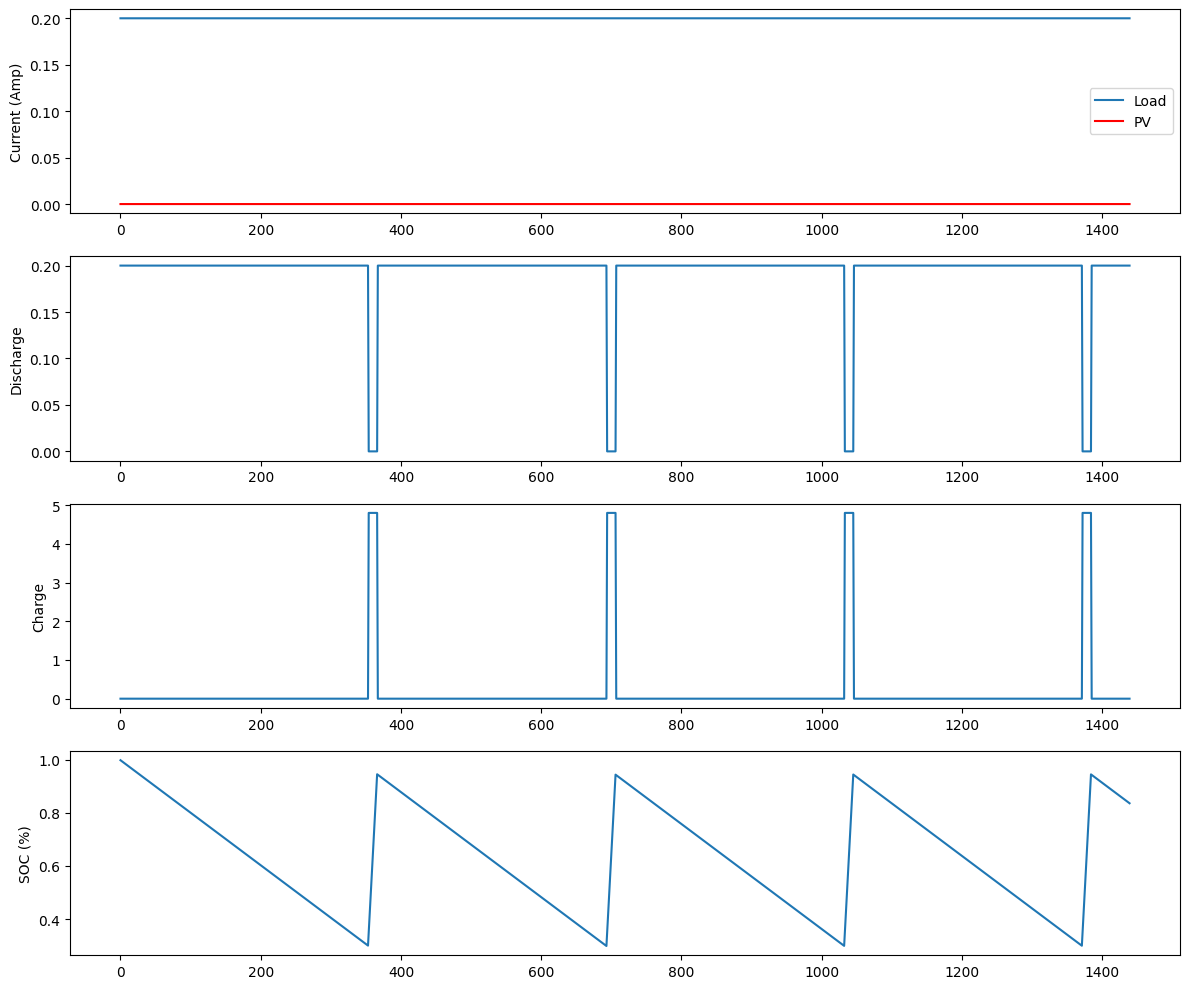

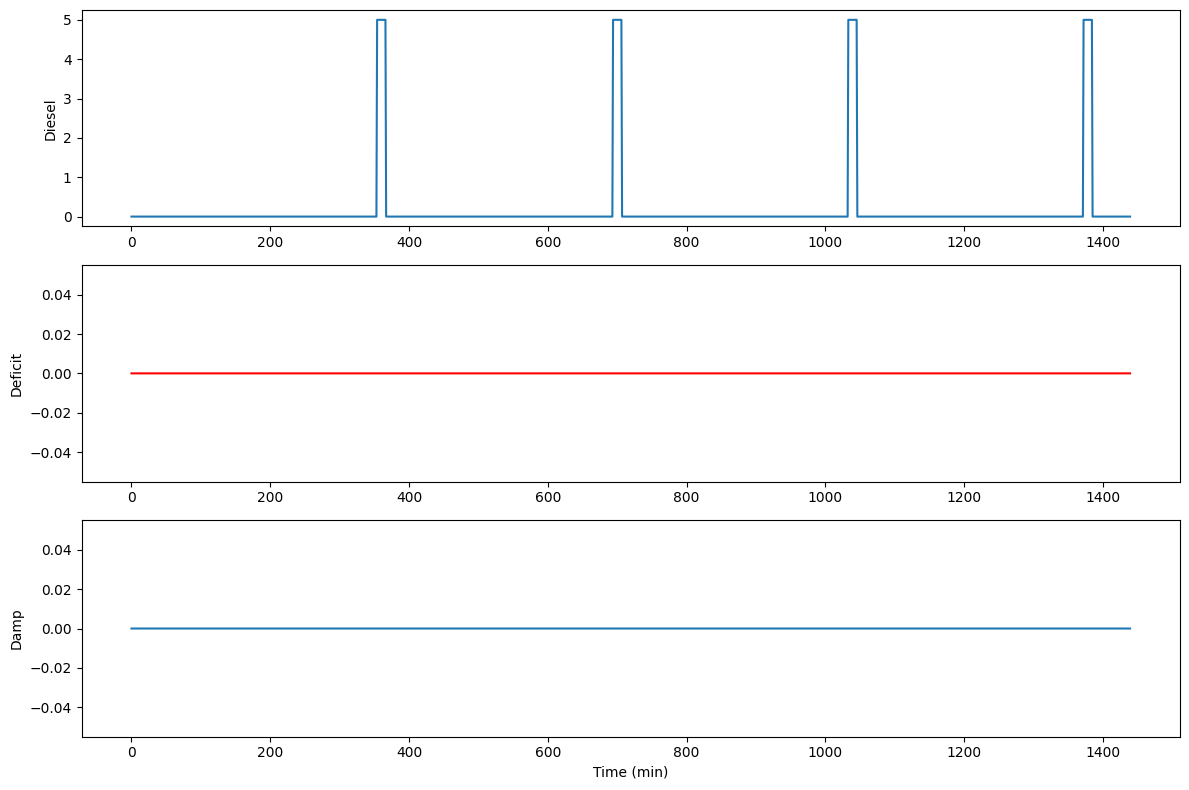

Excess energy: 0.0 kWh
Diesel consumption: 0.3122652866666667 Litres
Energy Deficit: 0.0 kWh
Energy Discharge: 1.0178666666666665 kWh
Number of times SOC < 0.3: 4


In [24]:
#Exercise 4.4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
import sympy as sp

# Clear equivalent (not needed in Python, but for completeness)
plt.close('all')

# %% (1) Data sources
fileName = 'Load for Ammar.xls'
sheetName1 = 'Sheet2'
sheetName2 = 'Sheet3'

# Read Excel data
df1 = pd.read_excel(fileName, sheet_name=sheetName1, usecols='A:B', skiprows=1, nrows=1440)
I_PV = df1.iloc[:, 0].values  # Column A
I_L = df1.iloc[:, 1].values   # Column B

# %% (2) System specifications
I_Diesel = 5                  # Maximum Diesel current
SOCmax = 1000
SOCi = SOCmax
V_B = 2                       # voltage of the used battery
DOD = 0.8                     # allowed depth of charge
SOCmin = SOCmax * (1 - DOD)
t1 = 1
SOC1 = 1
SOC3 = 0.3                    # Min. SOC of the battery
K = 0.8
D = 1e-5
ns = 6
SOC2 = SOC1
W = 0
A = 0.2461                    # fuel consumption coefficient (l/kWh)
T = 0.081451                  # fuel consumption coefficient (l/kWh)
n = 0

SOCfinal = []
Dieselfinal = []
SOCf = []
I_Loadf = []
I_Chargef = []
I_Dischargef = []
I_Batteryf = []
I_Deficitf = []
I_Dampf = []
I_Dieself = []
F_Cf = []

# %% Simulation
L = len(I_L)
I_net = np.zeros(L)
SOC = np.zeros(L)

for i in range(L):
    I_net[i] = I_PV[i] - I_L[i]

    # %% (4) Case: I_PV = I_L
    if I_net[i] == 0:
        if n == 0:
            I_Loadi = I_PV[i]
            I_Dampi = 0
            I_Batteryi = 0
            I_Chargei = 0
            I_Deficiti = 0
            I_Dieseli = 0
            I_Dischargei = 0
            F_Ci = 0

            if i == 0:
                SOCi = SOC1
            elif W == 0:
                SOCi = SOC1
            elif W == 1:
                SOCi = SOCf[i-1]

    # %% (5) Case: I_PV > I_L
    elif I_net[i] > 0 and n == 0:
        I_Loadi = I_L[i]

        if i == 0:
            SOCi = SOC1
            I_Dampi = I_net[i]
            I_Chargei = 0
            I_Dischargei = 0
            I_Batteryi = 0
            I_Deficiti = 0
            I_Dieseli = 0
            F_Ci = 0

        elif i > 0:
            if W == 0:
                SOCi = SOC1
                I_Dampi = I_net[i]

            elif W == 1:
                if SOCf[i-1] >= SOC1:
                    I_Dampi = I_net[i]
                    SOCi = SOCf[i-1]
                    I_Dischargei = 0
                    I_Batteryi = 0
                    I_Deficiti = 0
                    I_Dieseli = 0
                    I_Chargei = 0
                    F_Ci = 0

                elif SOCf[i-1] < SOC1:
                    I_Chargei = I_net[i]
                    I_Dischargei = 0
                    I_Batteryi = 0
                    I_Deficiti = 0
                    I_Dieseli = 0
                    I_Dampi = 0
                    F_Ci = 0

                    for t in [1]:
                        B = SOC2
                        V1 = (2 + 0.148 * B) * ns
                        R1 = (0.758 + 0.1309 / (1.06 - B)) * ns / SOCmax
                        R1 = float(R1)

                        # Symbolic integration
                        v = sp.Symbol('v')
                        integrand = K * V1 * I_net[i] - D * SOC2 * SOCmax
                        ee = float(sp.integrate(integrand, (v, 0, t)))
                        SOC_temp = SOC1 + (1/SOCmax) * ee
                        SOC2 = SOC_temp

                    SOC2 = float(SOC2)
                    SOC[i] = SOCf[i-1] + abs(SOC1 - SOC2)
                    SOCi = SOC[i]

    # %% (6) Case: I_PV < I_L
    elif I_net[i] < 0 or (I_net[i] > 0 and n >= 0):
        if W == 0:
            if n == 0:
                I_Dischargei = I_L[i] - I_PV[i]
                I_Loadi = I_PV[i] + I_Dischargei
                I_Batteryi = I_Dischargei
                I_Chargei = 0
                I_Deficiti = 0
                I_Dampi = 0
                I_Dieseli = 0
                F_Ci = 0

                for t in [1]:
                    B = SOC2
                    V1 = (1.926 + 0.124 * B) * ns
                    R1 = (0.19 + 0.1037 / (B - 0.14)) * ns / SOCmax

                    # Symbolic integration
                    v = sp.Symbol('v')
                    integrand = K * V1 * I_net[i] - D * SOC2 * SOCmax
                    ee = float(sp.integrate(integrand, (v, 0, t)))
                    SOC_temp = SOC1 + (1/SOCmax) * ee
                    SOC2 = SOC_temp

                SOC2 = float(SOC2)
                SOC[i] = SOC2
                SOCi = SOC[i]
                W = W + 1

        elif W == 1:
            if SOCf[i-1] > SOC3 and n == 0:
                I_Dischargei = I_L[i] - I_PV[i]
                I_Loadi = I_L[i]
                I_Batteryi = I_Dischargei
                I_Chargei = 0
                I_Deficiti = 0
                I_Dampi = 0
                I_Dieseli = 0
                F_Ci = 0

                for t in [1]:
                    B = SOC2
                    V1 = (1.926 + 0.124 * B) * ns
                    R1 = (0.19 + 0.1037 / (B - 0.14)) * ns / SOCmax

                    # Symbolic integration
                    v = sp.Symbol('v')
                    integrand = K * V1 * I_net[i] - D * SOC2 * SOCmax
                    ee = float(sp.integrate(integrand, (v, 0, t)))
                    SOC_temp = SOC1 + (1/SOCmax) * ee
                    SOC2 = SOC_temp

                SOC2 = float(SOC2)
                SOC[i] = SOCf[i-1] - abs(SOC1 - SOC2)
                SOCi = SOC[i]

            elif SOCf[i-1] <= SOC3 or n >= 0:
                if I_Diesel >= I_L[i]:
                    I_Loadi = I_L[i]
                    I_Dieseli = I_Diesel
                    I_Dischargei = 0
                    I_Deficiti = 0

                    if SOCf[i-1] < SOC1:
                        I_Chargei = I_PV[i] + I_Dieseli - I_L[i]
                        I_Dampi = 0

                        for t in [1]:
                            B = SOC2
                            V1 = (2 + 0.148 * B) * ns
                            R1 = (0.758 + 0.1309 / (1.06 - B)) * ns / SOCmax
                            R1 = float(R1)

                            # Symbolic integration
                            v = sp.Symbol('v')
                            integrand = K * V1 * I_Chargei - D * SOC2 * SOCmax
                            ee = float(sp.integrate(integrand, (v, 0, t)))
                            SOC_temp = SOC1 + (1/SOCmax) * ee
                            SOC2 = SOC_temp

                        SOC2 = float(SOC2)
                        SOC[i] = SOCf[i-1] + abs(SOC1 - SOC2)
                        SOCi = SOC[i]
                    else:
                        I_Chargei = 0
                        I_Dampi = I_PV[i] + I_Dieseli - I_L[i]
                        SOCi = SOC1

                    F_C = A * (220 * ((I_Diesel / 60) / 1000)) + \
                          T * (220 * ((I_Diesel / 60) / 1000))
                    F_Ci = F_C
                    n = n + 1

                elif I_Diesel < I_L[i] and SOCf[i-1] >= 0.8:
                    I_Dischargei = I_L[i] - I_Diesel
                    I_Loadi = I_L[i]
                    I_Batteryi = I_Dischargei
                    I_Chargei = 0
                    I_Deficiti = 0
                    I_Dampi = 0
                    I_Dieseli = I_Diesel
                    F_Ci = 0

                    for t in [1]:
                        B = SOC2
                        V1 = (1.926 + 0.124 * B) * ns
                        R1 = (0.19 + 0.1037 / (B - 0.14)) * ns / SOCmax

                        # Symbolic integration
                        v = sp.Symbol('v')
                        integrand = K * V1 * I_Dischargei - D * SOC2 * SOCmax
                        ee = float(sp.integrate(integrand, (v, 0, t)))
                        SOC_temp = SOC1 + (1/SOCmax) * ee
                        SOC2 = SOC_temp

                    SOC2 = float(SOC2)
                    SOC[i] = SOCf[i-1] - abs(SOC1 - SOC2)
                    SOCi = SOC[i]

                elif I_Diesel < I_L[i] and SOCf[i-1] <= 0.3:
                    I_Deficiti = I_L[i]

                if SOC[i] >= 0.9:
                    n = 0

    # Store results
    SOCf.append(SOCi)
    I_Loadf.append(I_Loadi)
    I_Chargef.append(I_Chargei)
    I_Dischargef.append(I_Dischargei)
    I_Batteryf.append(I_Batteryi)
    I_Deficitf.append(I_Deficiti)
    I_Dampf.append(I_Dampi)
    I_Dieself.append(I_Dieseli)
    F_Cf.append(F_Ci)

# Convert lists to numpy arrays
SOCf = np.array(SOCf)
I_Loadf = np.array(I_Loadf)
I_Chargef = np.array(I_Chargef)
I_Dischargef = np.array(I_Dischargef)
I_Batteryf = np.array(I_Batteryf)
I_Deficitf = np.array(I_Deficitf)
I_Dampf = np.array(I_Dampf)
I_Dieself = np.array(I_Dieself)
F_Cf = np.array(F_Cf)

# %% Post processing
DD = SOCf
SSS = np.sum(DD < 0.3)
LL = SSS

Excess_energy = ((np.sum(I_Dampf) / 60) * 220) / 1000
Diesel_consumption = np.sum(F_Cf)                         # Litres
Enrgy_Deficit = ((np.sum(I_Deficitf) / 60) * 220) / 1000  # kWh
Enrgy_Discharge = ((np.sum(I_Dischargef) / 60) * 220) / 1000

# %% Plotting
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(I_L, label='Load')
plt.plot(I_PV, 'red', label='PV')
plt.ylabel('Current (Amp)')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(I_Dischargef)
plt.ylabel('Discharge')

plt.subplot(4, 1, 3)
plt.plot(I_Chargef)
plt.ylabel('Charge')

plt.subplot(4, 1, 4)
plt.plot(SOCf)
plt.ylabel('SOC (%)')

plt.tight_layout()

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(I_Dieself)
plt.ylabel('Diesel')

plt.subplot(3, 1, 2)
plt.plot(I_Deficitf, 'red')
plt.ylabel('Deficit')

plt.subplot(3, 1, 3)
plt.plot(I_Dampf)
plt.ylabel('Damp')
plt.xlabel('Time (min)')

plt.tight_layout()
plt.show()

# Print results
print(f"Excess energy: {Excess_energy} kWh")
print(f"Diesel consumption: {Diesel_consumption} Litres")
print(f"Energy Deficit: {Enrgy_Deficit} kWh")
print(f"Energy Discharge: {Enrgy_Discharge} kWh")
print(f"Number of times SOC < 0.3: {LL}")
